In [1]:
import os
import torch
import sys
sys.path.append('../../')

In [2]:
import matplotlib.pyplot as plt
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.load import get_patched_data, get_patched_src

In [ ]:
def get_patched_data(data_pth, hr_dir, bs, in_sz, out_sz,
                     tfms=None, num_workers=4, noise=None, max_zoom=1.1):
    """This is a custom (unoptimal) method for loading a databunch for in-painting tasks"""
    src = get_patched_src(data_pth, hr_dir)
    
    data = (src
                .transform(tfms, size=in_sz, resize_method=ResizeMethod.CROP, tfm_y=False)
                .transform_y(None, size=out_sz, resize_method=ResizeMethod.CROP)
                .databunch(bs=bs, num_workers=num_workers)
                .normalize(imagenet_stats, do_y=True))
    data.c = 3
    data.train_ds.tfms_y = None
    return data


def get_patched_src(data_pth, hr_dir):
    hr_tifs = data_pth/f'{hr_dir}'

    def map_to_hr(x):
        return hr_tifs/x.relative_to(hr_tifs).with_suffix(".tif")

    src = (ImageImageList
            .from_folder(hr_tifs)
            .split_by_rand_pct()
            .label_from_func(map_to_hr))
    return src

In [22]:
# Modify accordingly to your data directories
path = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/')

hr_name = f'training/trainsets/hr/'  #  relative path to your images
hr_path = path/f'{hr_name}'
hr_files = sorted(list(hr_path.glob('*.tif')))  # retrieve list of filenames

print('Processing '+str(len(hr_files))+' files...')

Processing 99997 files...


## Generate Dataset for Inpainting Task

In [23]:
# custom transformer for randomized inpainting
def _custom_cutout(x, min_n_holes:uniform_int=5, max_n_holes:uniform_int=30,
                   min_length:uniform_int=5, max_length:uniform_int=15):
    "Cut out number of rectangular holes in image at random numbers, sizes, and locations."
    h,w = x.shape[1:]
    n_holes = np.random.randint(min_n_holes, max_n_holes)
    h_length = np.random.randint(min_length, max_length)
    w_length = np.random.randint(min_length, max_length)
    for n in range(n_holes):
        h_y = np.random.randint(0, h)
        h_x = np.random.randint(0, w)
        y1 = int(np.clip(h_y - h_length / 2, 0, h))
        y2 = int(np.clip(h_y + h_length / 2, 0, h))
        x1 = int(np.clip(h_x - w_length / 2, 0, w))
        x2 = int(np.clip(h_x + w_length / 2, 0, w))
        x[:, y1:y2, x1:x2] = 0
    return x

custom_cutout = TfmPixel(_custom_cutout, order=20)

In [24]:
tfms = [custom_cutout(), custom_cutout()]

In [25]:
img_size = 256
bs = 8
data = get_patched_data(path, hr_path, bs=bs,
                        in_sz=img_size, out_sz=img_size,
                        tfms=tfms)

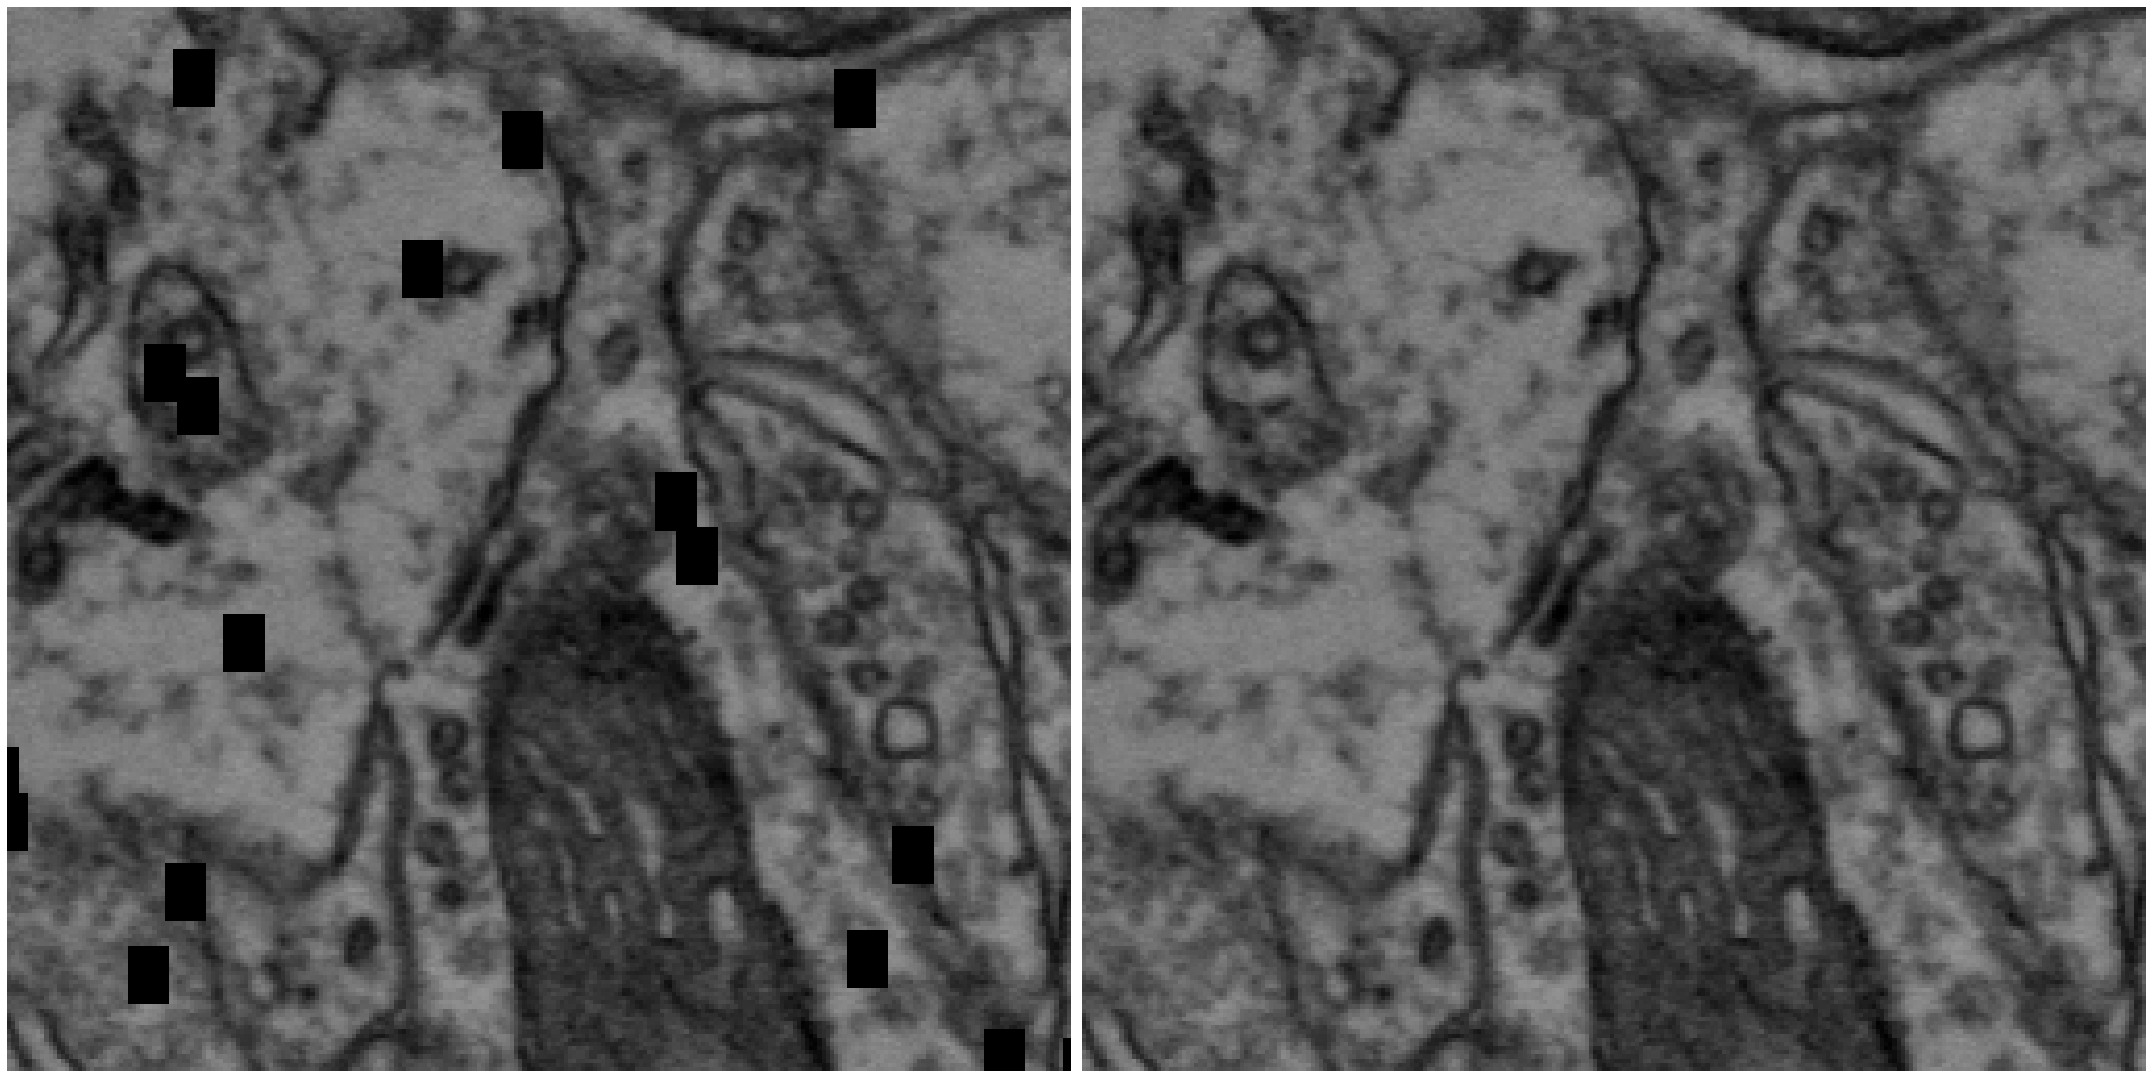

In [26]:
data.show_batch(rows=1, figsize=(30, 24))

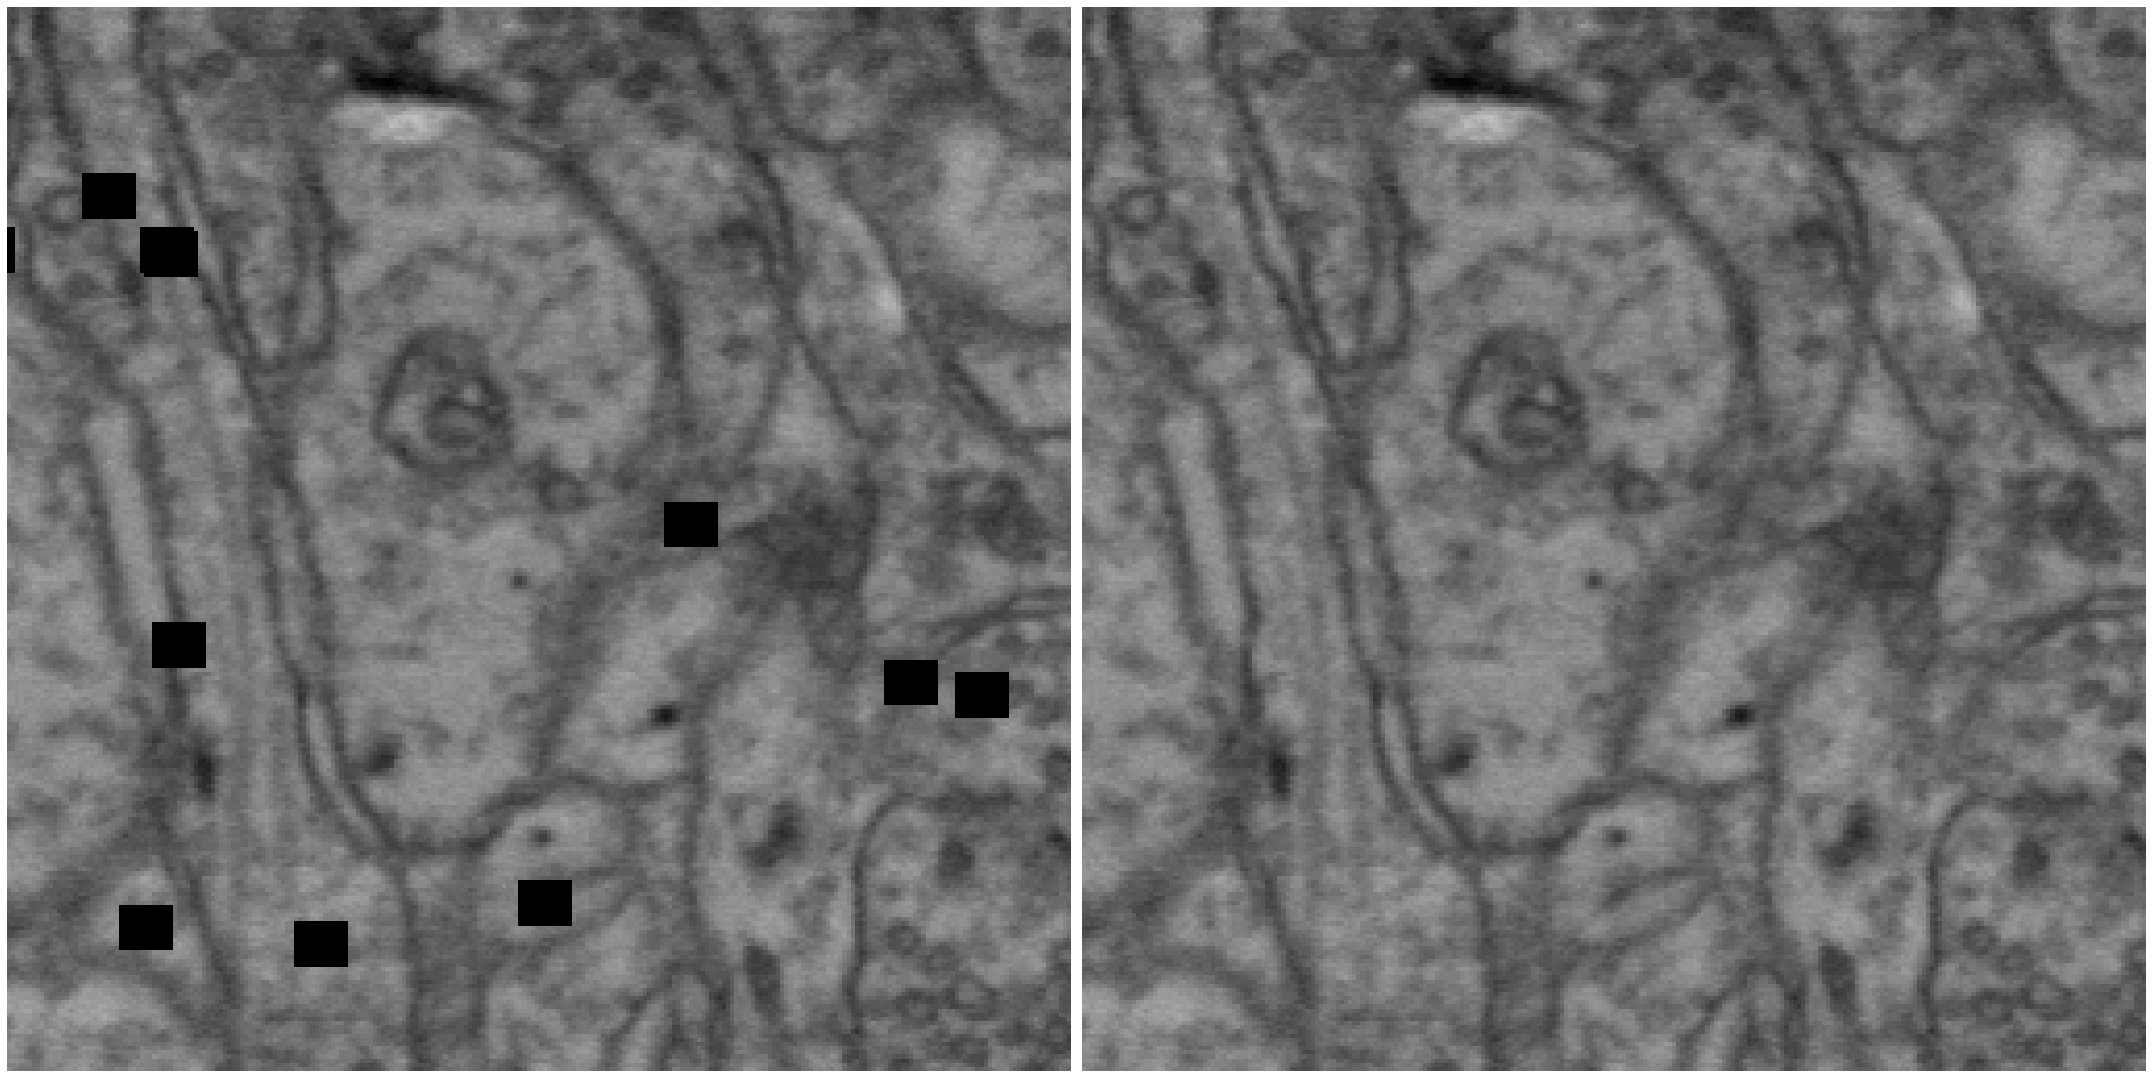

In [27]:
data.show_batch(rows=1, figsize=(30, 24))

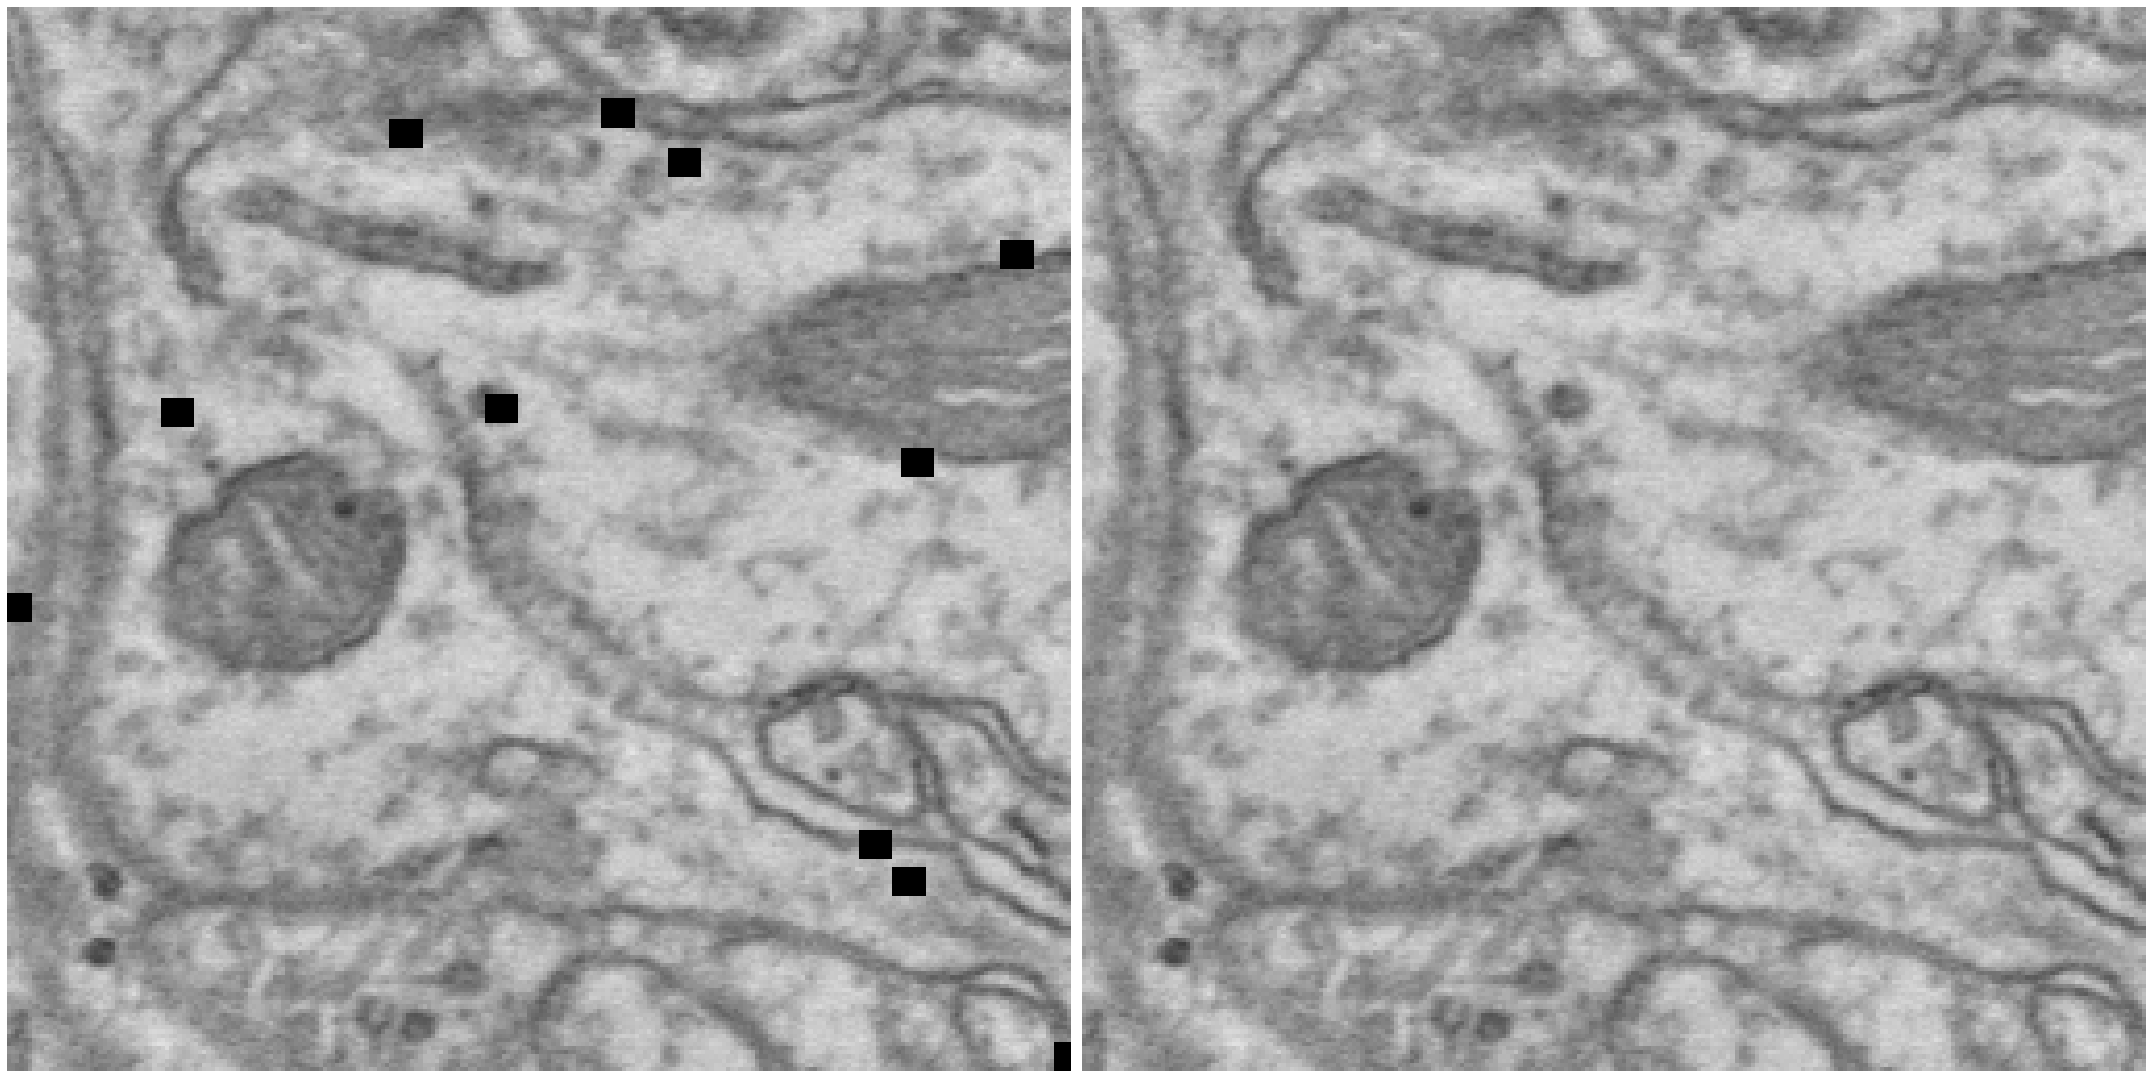

In [28]:
data.show_batch(rows=1, figsize=(30, 24))